# FactorGraph

A `FactorGraph` represents a factor graph, a bipartite graph connecting variables and factors. In GTSAM, the `FactorGraph` class (and its templated instantiations like `GaussianFactorGraph`, `NonlinearFactorGraph`, etc.) primarily stores a collection of factors.

This class serves as the base for different types of factor graphs. You typically work with specific instantiations like `gtsam.GaussianFactorGraph` or `gtsam.NonlinearFactorGraph`.

The total probability $P(X)$ represented by a factor graph is proportional to the product of its individual factor potentials $\phi_i$:
$$
P(X) \propto \prod_i \phi_i(X_i)
$$
where $X_i$ are the variables involved in factor $i$. In terms of error (negative log-likelihood):
$$
P(X) \propto \exp\left(-\sum_i \text{error}_i(X_i)\right)
$$
The total error for the graph given an assignment $X$ is the sum of the errors of the individual factors:
$$
\text{error}(X) = \sum_i \text{error}_i(X_i)
$$

<a href="https://colab.research.google.com/github/borglab/gtsam/blob/develop/gtsam/inference/doc/FactorGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install --quiet gtsam-develop

In [1]:
import gtsam
import numpy as np
import graphviz

# Example uses NonlinearFactorGraph, but concepts apply to others
from gtsam import NonlinearFactorGraph, PriorFactorPose2, BetweenFactorPose2, Pose2, Point3
from gtsam import symbol_shorthand

X = symbol_shorthand.X

## Initialization and Adding Factors

A `FactorGraph` is typically created empty and factors are added individually or from containers.

In [2]:
graph = NonlinearFactorGraph()

# Define noise models
prior_noise = gtsam.noiseModel.Diagonal.Sigmas(Point3(0.1, 0.1, 0.05))
odometry_noise = gtsam.noiseModel.Diagonal.Sigmas(Point3(0.2, 0.2, 0.1))

# Create factors
factor1 = PriorFactorPose2(X(0), Pose2(0, 0, 0), prior_noise)
factor2 = BetweenFactorPose2(X(0), X(1), Pose2(1, 0, 0), odometry_noise)
factor3 = BetweenFactorPose2(X(1), X(2), Pose2(1, 0, 0), odometry_noise)

# Add factors to the graph
graph.add(factor1)  # add is synonym for push_back
graph.push_back(factor2)

print(f"Graph size after adding factors: {graph.size()}")

Graph size after adding factors: 2


## Accessing Factors and Properties

In [3]:
print(f"Is graph empty? {graph.empty()}")
print(f"Number of factors (size): {graph.size()}")
print(f"Number of non-null factors (nrFactors): {graph.nrFactors()}") # Useful if factors were removed

# Access factor by index
retrieved_factor = graph.at(1)
print("Factor at index 1: ")
retrieved_factor.print()

# Get all unique keys involved in the graph
all_keys = graph.keys() # Returns a KeySet
print(f"Keys involved in the graph: {all_keys}")

# Iterate through factors
# for i, factor in enumerate(graph):
#     if factor:
#         print(f"Factor {i} keys: {factor.keys()}")

Is graph empty? False
Number of factors (size): 2
Number of non-null factors (nrFactors): 2
Factor at index 1: 
BetweenFactor(x0,x1)
  measured:  (1, 0, 0)
  noise model: diagonal sigmas [0.2; 0.2; 0.1];
Keys involved in the graph: x0x1


## Graph Error

The `error(Values)` method calculates the total error of the graph for a given assignment of variable values. This is the sum of the errors from each individual factor.

In [4]:
values = gtsam.Values()
values.insert(X(0), Pose2(0, 0, 0))
values.insert(X(1), Pose2(1, 0, 0))
values.insert(X(2), Pose2(2, 0, 0))

total_error1 = graph.error(values)
print(f"Total graph error at ground truth: {total_error1}")

# Introduce an error
values.update(X(2), Pose2(1, 0, 0))
total_error2 = graph.error(values)
print(f"Total graph error with incorrect x2: {total_error2:.1f}")

Total graph error at ground truth: 0.0
Total graph error with incorrect x2: 0.0


## Graph Visualization

Factor graphs can be visualized using Graphviz via the `dot()` method.

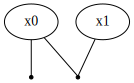

In [5]:
graphviz.Source(graph.dot(values))

## Elimination

A key purpose of factor graphs is inference via variable elimination. `FactorGraph` itself doesn't perform elimination, but its derived classes (like `GaussianFactorGraph`, `SymbolicFactorGraph`) inherit `eliminateSequential` and `eliminateMultifrontal` methods from `EliminateableFactorGraph`.